- 添加更多的特征，例如季度
- 使用网格搜索技术设置超参数

In [79]:
import xgboost as xgb
import os
import seaborn as sns
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.metrics import mean_squared_error, r2_score
from time import time
from scipy import stats
import joblib
import pickle
import pylab as plt
from sklearn.model_selection import cross_val_score, GridSearchCV
import torch.nn as nn
import lightgbm as lgb
from utils import *


import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
np.set_printoptions(suppress=True)
sns.set_style({'font.sans-serif': ['simhei', 'Arial']})   # 解决画图中文乱码

%matplotlib inline

In [2]:
data = pd.read_csv('./data.csv', encoding='GBK')
data.data_date = pd.to_datetime(data.data_date)
data.head(1)

,id,site_id,asin,data_date,product_title,ordered_revenue,ordered_revenue_of_total,ordered_revenue_last_year,ordered_units,ordered_units_of_total,ordered_units_prior_period,ordered_units_last_year,subcategory_sales_rank,average_sales_price,average_sales_price_prior_period,glance_views,change_in_glance_view_prior_period,change_in_gv_last_year,conversion_rate,rep_oos,rep_oos_of_total,rep_oos_prior_period,lbb_price,create_time,update_time
0,1,eb766123-9f24-436e-9117-49c739816794,B07GJBBGHG,2021-01-02,COSORI 5.8QT Electric Hot Air Fryers Oven Oill...,153827.1800,0.1300,1.2600,1284,0.0600,-0.1300,1.2600,1.0000,119.8000,0.0000,40220.0000,0.0000,1.1900,0.0300,0.0200,0.1400,0.1500,0.0000,2021/1/4 6:48,2021/1/4 6:48


In [3]:
alldata = data[(data.asin == 'B07GJBBGHG')][['data_date',
                                             'ordered_units']].sort_values('data_date')
alldata.shape

(626, 2)

In [4]:
alldata.head(2)

,data_date,ordered_units
15966,2019-12-02,10709
15931,2019-12-03,1353


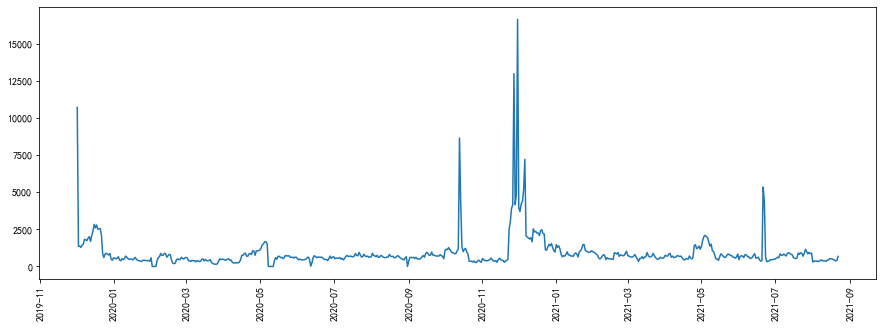

In [5]:
plt.figure(figsize=(15, 5))
plt.xticks(rotation=90)
plt.plot(alldata.data_date, alldata.ordered_units)

<AxesSubplot:xlabel='ordered_units', ylabel='Density'>

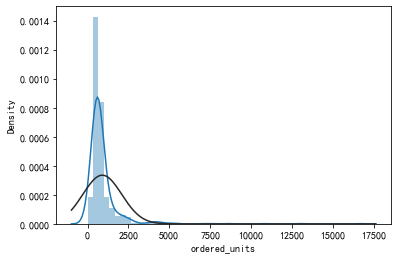

In [6]:
sns.distplot(alldata.ordered_units, fit=stats.norm)

In [7]:
alldata.ordered_units.skew(), np.log1p(alldata.ordered_units).skew()

(7.5340006644908195, -3.616558075453425)

In [8]:
from scipy.special import boxcox1p
boxcox1p(alldata.ordered_units, 0.21).skew()

0.022899662729770277

<AxesSubplot:xlabel='ordered_units', ylabel='Density'>

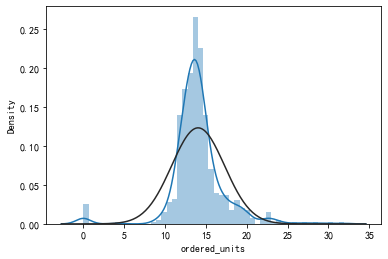

In [10]:
sns.distplot(boxcox1p(alldata.ordered_units, 0.21), fit=stats.norm)

## 数据预处理

### 异常值，删除小于等于0的数值和离群点

In [15]:
alldata[alldata.ordered_units <= 0].index

Int64Index([13872, 13839, 13809, 13778, 10365, 10327, 10290, 10255, 10220,
            5849],
           dtype='int64')

In [16]:
alldata.drop(alldata[alldata.ordered_units <= 0].index, inplace=True)

<AxesSubplot:xlabel='ordered_units'>

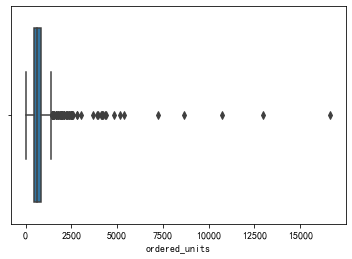

In [17]:
sns.boxplot(alldata.ordered_units)

In [18]:
alldata[alldata.ordered_units > 5000].index

Int64Index([15966, 3924, 1824, 1680, 1437, 1387, 25152], dtype='int64')

In [19]:
alldata.drop(alldata[alldata.ordered_units > 5000].index, inplace=True)

In [20]:
alldata.shape

(609, 2)

### 设置样本权重

In [21]:
alldata['weight'] = alldata.data_date.apply(lambda x: (
    x - pd.to_datetime('2019-12-02')).days)

In [22]:
alldata.head(1)

,data_date,ordered_units,weight
15931,2019-12-03,1353,1


### 缺失值

In [23]:
alldata.isnull().sum()

data_date        0
ordered_units    0
weight           0
dtype: int64

无缺失值不用处理

### 创造特征

In [24]:
def create_feature(df):
    df['year'] = df.data_date.dt.year
    df['month'] = df.data_date.dt.month
    df['day'] = df.data_date.dt.day
    df['weekday'] = df.data_date.dt.weekday  # 周几
    df['quarter'] = df.data_date.dt.quarter  # 季度
    df['weekofyear'] = df.data_date.dt.weekofyear

    df.drop('data_date', axis=1, inplace=True)
    return df

In [25]:
alldata = create_feature(alldata)

In [26]:
alldata.head(3)

,ordered_units,weight,year,month,day,weekday,quarter,weekofyear
15931,1353,1,2019,12,3,1,4,49
15897,1369,2,2019,12,4,2,4,49
15864,1282,3,2019,12,5,3,4,49


In [40]:
x = alldata.drop('ordered_units', axis=1)
y = alldata['ordered_units']
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.1)

### 编码

In [44]:
x_train.head(2)

,weight,year,month,day,weekday,quarter,weekofyear
786,382,2020,12,18,4,4,51
3510,325,2020,10,22,3,4,43


In [45]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
x_train = encoder.fit_transform(x_train)
x_test = encoder.transform(x_test)
x_train.shape, x_test.shape

((548, 658), (61, 658))

## 训练

### sklearn api

In [76]:
ts = time()
print(cross_val_score(xgbr, x_train, y_train, cv=5).mean())
time() - ts

0.7119004063222762


1.9064319133758545

In [75]:
xgbr = XGBRegressor(n_estimators=200,
                    learning_rate=0.35,
                    max_depth=7,
                    subsample=0.6,
                    colsample_bytree=0.7,
                    objective='reg:squarederror',
                    base_score=0.5,
                    gamma=1,
                    n_jobs=8, verbosity=1)

xgbr.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)],
         early_stopping_rounds=20, verbose=True)

[0]	validation_0-rmse:730.29120	validation_1-rmse:849.63574
[1]	validation_0-rmse:548.03265	validation_1-rmse:685.94550
[2]	validation_0-rmse:445.05035	validation_1-rmse:618.08124
[3]	validation_0-rmse:360.31766	validation_1-rmse:570.92969
[4]	validation_0-rmse:320.08435	validation_1-rmse:540.61456
[5]	validation_0-rmse:285.88519	validation_1-rmse:524.13318
[6]	validation_0-rmse:266.55045	validation_1-rmse:517.20209
[7]	validation_0-rmse:242.85706	validation_1-rmse:514.03046
[8]	validation_0-rmse:226.18507	validation_1-rmse:515.51538
[9]	validation_0-rmse:214.72295	validation_1-rmse:511.90680
[10]	validation_0-rmse:202.82060	validation_1-rmse:509.52267
[11]	validation_0-rmse:193.18378	validation_1-rmse:510.80603
[12]	validation_0-rmse:180.08632	validation_1-rmse:508.97324
[13]	validation_0-rmse:172.59659	validation_1-rmse:508.85642
[14]	validation_0-rmse:166.67801	validation_1-rmse:507.61209
[15]	validation_0-rmse:162.74281	validation_1-rmse:507.06421
[16]	validation_0-rmse:158.97862	v

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.35, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.6,
             tree_method='exact', validate_parameters=1, verbosity=1)

In [ ]:
# 网格搜索
# params_grid = {'learning_rate': np.arange(0, 1, 0.05)}

# params_grid = {'max_depth': range(0, 8, 1)}

# params_grid = {'subsample': np.arange(0, 1, 0.05)}
params_grid = {'colsample_bytree': np.arange(0, 1, 0.05)}

gridCV = GridSearchCV(xgbr, params_grid, cv=5, scoring='r2', n_jobs=8)

ts = time()
gridCV.fit(x_train, y_train)
print(time() - ts)
gridCV.best_params_, gridCV.best_score_

In [ ]:
result = xgbr.evals_result()
plt.plot(result['validation_0']['rmse'])
plt.plot(result['validation_1']['rmse'])

### xgboost api

In [38]:
dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test, y_test)

params = {'eta': 0.3,
          'objective': 'reg:squarederror',
          'gamma': 0,
          'max_depth': 5,
          'subsample': 0.5,
          'colsample_bytree': 1,
          'base_score': 0.5,
          'n_jobs': 8}

a = {}  # 记录验证集结果
model = xgb.train(params, dtrain, 300, early_stopping_rounds=20, evals=[
                  (dtest, 'test')], evals_result=a, verbose_eval=True)

[0]	test-rmse:787.05859
[1]	test-rmse:605.59271
[2]	test-rmse:535.71790
[3]	test-rmse:504.41638
[4]	test-rmse:451.57785
[5]	test-rmse:416.67691
[6]	test-rmse:368.91260
[7]	test-rmse:337.75443
[8]	test-rmse:336.24973
[9]	test-rmse:334.07410
[10]	test-rmse:320.31738
[11]	test-rmse:320.45258
[12]	test-rmse:305.20642
[13]	test-rmse:285.16476
[14]	test-rmse:286.65512
[15]	test-rmse:284.19476
[16]	test-rmse:284.05826
[17]	test-rmse:283.70371
[18]	test-rmse:279.53226
[19]	test-rmse:281.19687
[20]	test-rmse:277.47406
[21]	test-rmse:278.99527
[22]	test-rmse:273.31439
[23]	test-rmse:263.51685
[24]	test-rmse:261.43713
[25]	test-rmse:255.99350
[26]	test-rmse:256.36807
[27]	test-rmse:255.47286
[28]	test-rmse:254.09540
[29]	test-rmse:256.87180
[30]	test-rmse:258.02121
[31]	test-rmse:252.14825
[32]	test-rmse:259.23050
[33]	test-rmse:261.94702
[34]	test-rmse:259.51361
[35]	test-rmse:260.83997
[36]	test-rmse:257.71121
[37]	test-rmse:259.52267
[38]	test-rmse:266.07889
[39]	test-rmse:259.49432
[40]	test-

## 测试

### sklearn api

In [77]:
y_pred = xgbr.predict(x_test)
print('metrics1: {:.3f}\nmetrics2: {:.3f}\nr2: {:.3f}'.format(metrics1(y_test, y_pred),
                                                              metrics2(y_test, y_pred),
                                                              r2_score(y_test, y_pred)))

metrics1: 0.931
metrics2: 0.781
r2: 0.520


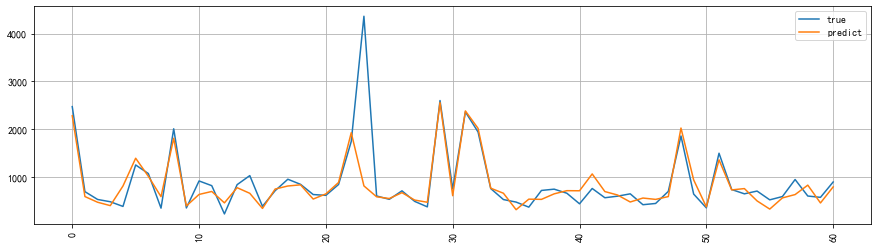

In [78]:
plt.figure(figsize=(15, 4))
plt.plot(y_test.values, label='true')
plt.plot(y_pred, label='predict')
plt.xticks(rotation=90)
plt.grid()
plt.legend()

### xgboost api

In [35]:
dtest = xgb.DMatrix(x_test, y_test)

In [36]:
y_pred = model.predict(dtest)
print('metrics1: {:.3f}\nmetrics2: {:.3f}\nr2: {:.3f}'.format(metrics1(y_test, y_pred),
                                                              metrics2(
                                                                  y_test, y_pred),
                                                              r2_score(y_test, y_pred)))

metrics1: 0.939
metrics2: 0.732
r2: 0.858


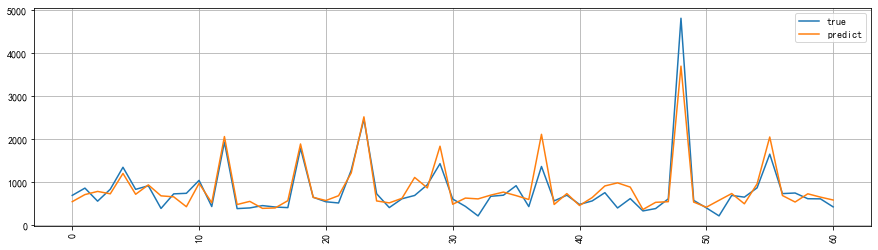

In [37]:
plt.figure(figsize=(15, 4))
plt.plot(y_test.values, label='true')
plt.plot(y_pred, label='predict')
plt.xticks(rotation=90)
plt.grid()
plt.legend()

In [ ]:
model.get_score(importance_type='gain')

In [ ]:
xgb.to_graphviz(model, num_trees=0)

In [ ]:
import xgboost
from xgboost import XGBClassifier
from sklearn.datasets import load_iris

iris = load_iris()
x, y = iris.data, iris.target
model = XGBClassifier()
model.fit(x, y)
# 如果输入是没有表头的array,会自动以f1,f2开始,需要更换表头
# 画树结构图的时候也需要替换表头

model.get_booster().feature_names = iris.feature_names
# max_num_features指定排名最靠前的多少特征
# height=0.2指定柱状图每个柱子的粗细,默认是0.2
# importance_type='weight'默认是用特征子树中的出现次数(被选择次数),还有"gain"和"cover"
xgboost.plot_importance(model, max_num_features=5, importance_type='gain')

# f_score就是feature score
model.feature_importances_  # 这里的特征重要性就是gain进行归一化之后的值

In [ ]:
model.feature_importances_.sum()

In [ ]:
2.9918/(2.9918+1.3149+0.0727+0.0424)

In [ ]:
xgb.to_graphviz(model, num_trees=1)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
dt = DecisionTreeClassifier(max_depth=2)

In [ ]:
dt.fit(x, y)

In [ ]:
import graphviz
from sklearn import tree
import pydotplus
from IPython.display import Image

In [ ]:
# 对于决策树来说，特征重要性就等于这个特征分裂的时候的总信息增益，这个特征有可能分裂，加到一起就行
dt.feature_importances_

In [ ]:
dot = tree.export_graphviz(dt)
graph = pydotplus.graph_from_dot_data(dot)
Image(graph.create_png())